In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import deep learning libraries and other needed libraries
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam, SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
#load dataset
train_data = pd.read_csv('/content/drive/My Drive/592TopicsDataScience/Final Project/test.csv')
train_data.columns = ["Time", "ECG", "Ax", "Ay", "Az"]
train_data.head()

,Time,ECG,Ax,Ay,Az
0,0.008333,134.76,0.22310,-0.15131,0.87346
1,0.016667,117.64,0.21813,-0.15153,0.87047
2,0.025000,144.96,0.21896,-0.15314,0.85289
3,0.033333,160.57,0.21804,-0.15625,0.86721
4,0.041667,177.87,0.21802,-0.15437,0.87482


In [ ]:
print("Shape of Training data: ",train_data.shape)

Shape of Training data:  (335991, 5)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335991 entries, 0 to 335990
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    335991 non-null  float64
 1   ECG     335991 non-null  float64
 2   Ax      335991 non-null  float64
 3   Ay      335991 non-null  float64
 4   Az      335991 non-null  float64
dtypes: float64(5)
memory usage: 12.8 MB


In [ ]:
sample_freq = 120 # sampling frequency
total_samples = train_data.shape[0] # total samples
total_set_samples = int(np.floor(train_data.shape[0]/sample_freq)*sample_freq)
print("Sampling Frequency: {}\n Total Samples: {}\n Total Set Samples: {}".format(sample_freq,total_samples,total_set_samples))

Sampling Frequency: 120
 Total Samples: 335991
 Total Set Samples: 335880


In [ ]:
# preprocess data
X_i=train_data[["Ax", "Ay", "Az"]].to_numpy()
X_i=X_i[48:] # take samples after 48 as there was delay in the signal
Y_i=train_data[["ECG"]].to_numpy()
Y_i=Y_i[:-48] # remove last 48 samples to make it compatible to input X
time_stamp = train_data[["Time"]].to_numpy()

In [ ]:
validation_samples = int(0.20* total_samples)
print(validation_samples)

67198


In [ ]:
X_train, X_test, y_train, y_test = X_i[:-validation_samples],X_i[-validation_samples:],Y_i[:-validation_samples],Y_i[-validation_samples:],

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

total_train_samples = X_train.shape[0]
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

total_val_samples = X_test.shape[0]

time_stamp_v = time_stamp[-validation_samples:]

X_train shape: (268745, 3)
y_train shape: (268745, 1)
X_test shape: (67198, 3)
y_test shape: (67198, 1)


In [ ]:
# normalise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
Y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.fit_transform(X_test)
Y_test_scaled = scaler.fit_transform(y_test)

# create training data for NN
X,Y,Xt,Yt,tm = [],[],[],[],[]
stride = 60
for i in range(0,total_train_samples-stride):
  X.append(X_train_scaled[i:i+stride])
  Y.append(Y_train_scaled[i+stride-1])

for i in range(0,total_val_samples-stride):
  Xt.append(X_test_scaled[i:i+stride])
  Yt.append(Y_test_scaled[i+stride-1])
  tm.append(time_stamp_v[i+stride-1])

TM = np.array(tm)
X = np.array(X)
print("Input X shape:",X.shape)
Y = np.array(Y)
# Y = np.array(Y).reshape(-1,1,sample_freq)
print("Input Y shape:",Y.shape)

print("# of sets: {}\n# of timesteps: {}\n# features: {}\n".format(X.shape[0],X.shape[1],X.shape[2]))

# sets,timesteps,features,outputs = X.shape[0],X.shape[1],X.shape[2],Y.shape[2]

Xt = np.array(Xt)
Yt = np.array(Yt)

print("Test X shape:",Xt.shape)
print("Test Y shape:",Yt.shape)
# Y = np.median(Y,axis=2)
# print("Input Y shape:",Y.shape)
# Y = np.array(Y).reshape(-1,1,120)

Input X shape: (268685, 60, 3)
Input Y shape: (268685, 1)
# of sets: 268685
# of timesteps: 60
# features: 3

Test X shape: (67138, 60, 3)
Test Y shape: (67138, 1)


In [ ]:
#create model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=10, activation='relu', input_shape=(stride,3)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 51, 128)           3968      
_________________________________________________________________
flatten (Flatten)            (None, 6528)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1305800   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,329,969
Trainable params: 1,329,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile model
batch_size=64
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(X,Y,batch_size=batch_size,epochs=30,verbose=1,validation_data=(Xt, Yt))

Epoch 1/30
4199/4199 [==============================] - 20s 3ms/step - loss: 0.7991 - accuracy: 0.0000e+00 - val_loss: 1.1331 - val_accuracy: 0.0000e+00
Epoch 2/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.4359 - accuracy: 0.0000e+00 - val_loss: 0.9842 - val_accuracy: 0.0000e+00
Epoch 3/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.3791 - accuracy: 0.0000e+00 - val_loss: 1.1002 - val_accuracy: 0.0000e+00
Epoch 4/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.3574 - accuracy: 0.0000e+00 - val_loss: 1.0985 - val_accuracy: 0.0000e+00
Epoch 5/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.3178 - accuracy: 0.0000e+00 - val_loss: 1.2764 - val_accuracy: 0.0000e+00
Epoch 6/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.2944 - accuracy: 0.0000e+00 - val_loss: 1.3301 - val_accuracy: 0.0000e+00
Epoch 7/30
4199/4199 [==============================] - 13s 3ms/step - loss: 0.272

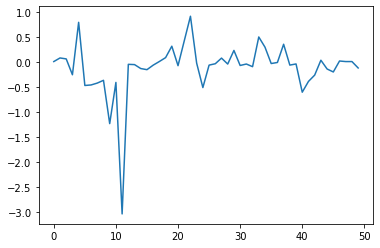

In [ ]:
# predict model
y1t = model.predict(Xt)
plt.figure()
plt.plot(y1t[:50])